### **MRUNAL VINAY JADHAV**
**ASSIGNMENT 3** -
**DATA 603**

In [ ]:
# Install dependencies
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar xf spark-3.1.2-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install py4j

# Set environment variables for Spark
import os
os.environ['SPARK_HOME'] = '/content/spark-3.1.2-bin-hadoop2.7'
os.environ['PYTHONPATH'] = os.path.join(os.environ['SPARK_HOME'], 'python') + ":" + os.path.join(os.environ['SPARK_HOME'], 'python', 'lib', 'py4j-*.zip')

# Initialize findspark
import findspark
findspark.init()

# Start Spark session
import pyspark
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder.master("local[*]").appName("ChicagoCrime").getOrCreate()

In [ ]:
#reading the file
df = spark.read.csv('/content/Crimes_-_2001_to_Present_20250408.csv',header=True)

# **QUICK EDA**

In [ ]:
df.show(10)

+--------+-----------+--------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|                Date|               Block|IUCR|        Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+--------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|13311263|   JG503434|07/29/2022 03:39:...|     023XX S TROY ST|1582|OFFENSE INVOLVING...|   CHILD PORNOGRAPHY|           RE

In [ ]:
df.count()

8289136

Cleaning the data

In [ ]:
#Cleaning the data
df_drop = df.dropna()
count = df_drop.count()
print('rows after eliminating null values:', count)

rows after eliminating null values: 7581478


In [ ]:
from pyspark.sql.functions import col, year, hour, when
from pyspark.sql.functions import to_timestamp
from datetime import datetime

# convert date format
df_date = df_drop.withColumn('Date', to_timestamp('Date', 'MM/dd/yyyy hh:mm:ss a'))

#data for last 10 years
now = datetime.now().year
tenyears = df_date.filter(year(col('Date'))>=(now - 10))

#removing records for some crimes
remove_crime = ['NON-CRIMINAL (SUBJECT SPECIFIED)','OTHER OFFENSE', 'STALKING', 'NON-CRIMINAL','ARSON']
filter_crime = tenyears.filter(~col('Primary Type').isin(remove_crime))

#Merging similar crimes
filter_crime = filter_crime.withColumn('Primary Type', when(col('Primary Type')=='SEX OFFENSE','SEXUAL OFFENSE').when(col('Primary Type')=='PROSTITUTION', 'SEXUAL OFFENSE').otherwise(col('Primary Type')))

#analyze
#1. Show year-wise trend of the crime for last ten years.
filter_crime = filter_crime.withColumn('Year', year(col('Date')))
year_trend = filter_crime.groupBy('Year').count().orderBy('Year')
year_trend.show()


+----+------+
|Year| count|
+----+------+
|2015|239904|
|2016|248557|
|2017|246538|
|2018|245354|
|2019|240850|
|2020|193876|
|2021|187555|
|2022|219010|
|2023|243252|
|2024|238764|
|2025| 47536|
+----+------+



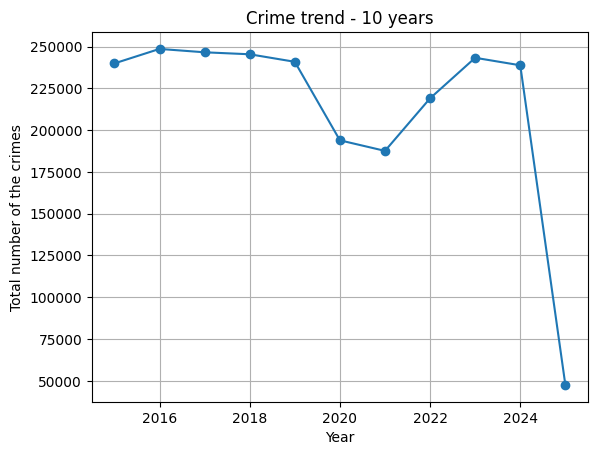

In [ ]:
# Plot
import matplotlib.pyplot as plt

year_trend = year_trend.toPandas()
plt.plot(year_trend['Year'], year_trend['count'], marker='o')
plt.title('Crime trend - 10 years')
plt.ylabel('Total number of the crimes')
plt.xlabel('Year')
plt.grid(True)
plt.show()

In [ ]:
#2. Find out at which hour of the day crime is highest.
filter_crime = filter_crime.withColumn('Hour', hour(col('Date')))
hr_trend = filter_crime.groupBy('Hour').count().orderBy('count', ascending=False)
hr_trend.show()

+----+------+
|Hour| count|
+----+------+
|   0|135949|
|  12|135726|
|  18|131136|
|  19|128348|
|  17|127967|
|  15|127852|
|  16|125322|
|  20|123325|
|  14|116080|
|  21|114827|
|  22|112308|
|  13|110148|
|  11|104122|
|  10|100635|
|   9|100356|
|  23| 97240|
|   8| 79132|
|   1| 75635|
|   2| 66240|
|   7| 56984|
+----+------+
only showing top 20 rows



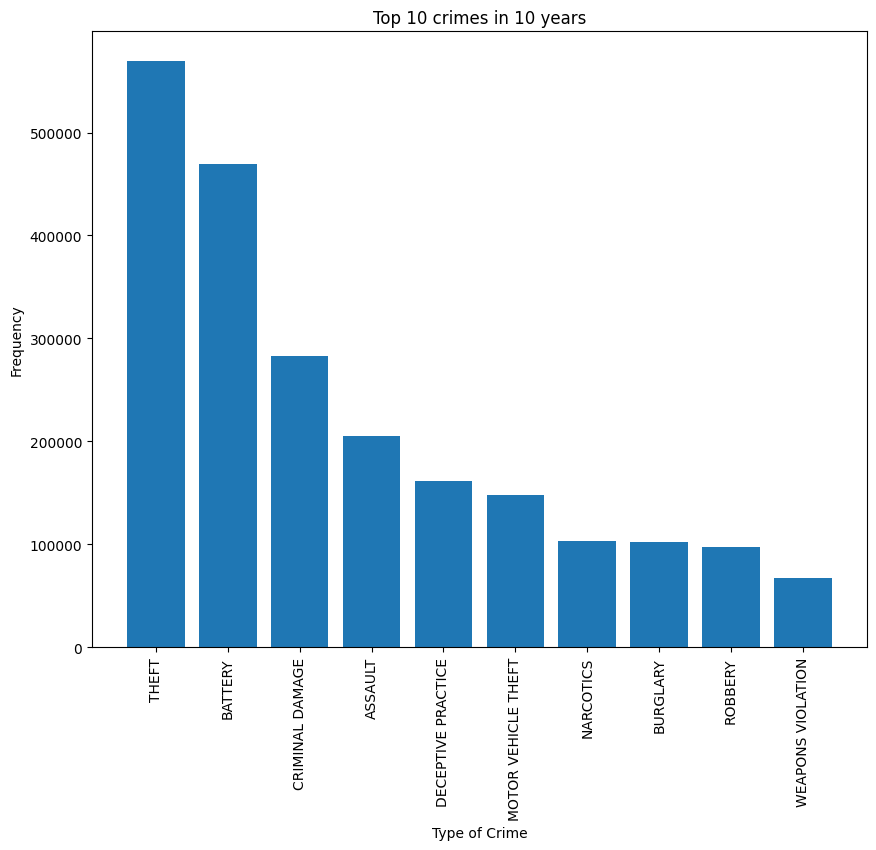

In [ ]:
#3. Find top ten crimes and present them as a bar chart.
crime = filter_crime.groupBy('Primary Type').count().orderBy('count',ascending=False)
topten = crime.limit(10)
topten_crime = topten.toPandas()

plt.figure(figsize=(10,8))
plt.bar(topten_crime['Primary Type'], topten_crime['count'])
plt.title('Top 10 crimes in 10 years')
plt.ylabel('Frequency')
plt.xlabel('Type of Crime')
plt.xticks(rotation=90)
plt.show()